In [22]:
import os, sys, time 
#, math
# from natsort import natsorted, ns

# import numpy as np
# import cv2
import matplotlib.pyplot as plt
# import cma
# from PIL import Image
import glob
# import re
from tifffile import imwrite

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

# from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
# from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
# from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen


from utils import *

In [2]:
use_padding = True
pad_width = 50
angular_step_in_deg = 3.6

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
#data_path = "4thCotober_imageAngle/"
#data_path = "23OctoberImage/"
data_path = "25OctoberData/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

/Users/eese10/PROGRAMMING/GitHub/MyProjects


In [10]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [11]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [12]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

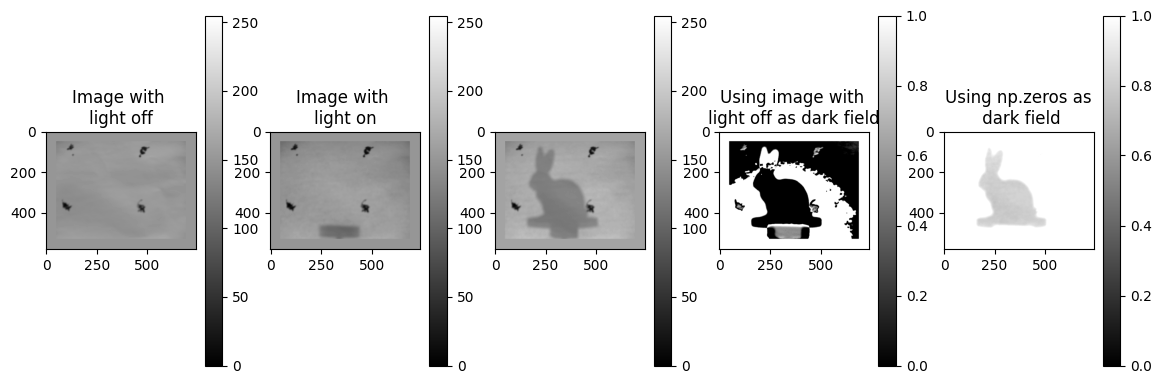

In [13]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [14]:
I_flat = I_flat2

In [23]:
if not os.path.exists(data_path + "/flat_images"):
    os.mkdir(data_path + "/flat_images")

for i, img in enumerate(I_flat):
    imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)

In [24]:
#sod = 43
#sod =47
#sod = 48
#sdd = 61
#for rabbit
#sod=41
#sdd=51
sod=104
sdd=130
#sod = 25
#sdd=61

In [25]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj1 = 5
y_obj1 = 0
z_obj1 = 0

x_obj2 = 5
y_obj2 = 0
z_obj2 = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj1,
    y_obj1,
    z_obj1,

    alpha_x, 
    alpha_y,
    alpha_z,

    x_obj2,
    y_obj2,
    z_obj2,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [27]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(current_folder + "/simulation2.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


Tue Nov  7 16:44:12 2023 ---- Create window (ID: -1)
Tue Nov  7 16:44:12 2023 ---- Initialise GLFW
Tue Nov  7 16:44:12 2023 ---- Create an OpenGL window with a 3.2 context.
Tue Nov  7 16:44:12 2023 ---- Make the window's context current
Tue Nov  7 16:44:12 2023 ---- Initialise GLEW
Tue Nov  7 16:44:13 2023 ---- OpenGL vendor: Intel Inc.
Tue Nov  7 16:44:13 2023 ---- OpenGL renderer: Intel(R) Iris(TM) Plus Graphics 650
Tue Nov  7 16:44:13 2023 ---- OpenGL version: 4.1 INTEL-16.4.5
Tue Nov  7 16:44:13 2023 ---- Cannot use OpenGL 4.5. You live in the past.
Tue Nov  7 16:44:13 2023 ---- Use OpenGL 3.2.
Tue Nov  7 16:44:13 2023 ---- Initialise the X-ray renderer if needed and if possible


In [28]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [30]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


Tue Nov  7 16:44:13 2023 ---- Initialise the renderer
Tue Nov  7 16:44:13 2023 ---- Initialise the renderer


In [31]:
# Load our samples
json2gvxr.initSamples(verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

Tue Nov  7 16:44:14 2023 ---- file_name:	/Users/eese10/PROGRAMMING/GitHub/MyProjects/Rabbit.stl	nb_faces:	75710	nb_vertices:	227130	bounding_box (in cm):	(-4.47596e-08, -1.23532e-07, -9.08006e-08)	(2.28946, 2.54, 2.40125)
Tue Nov  7 16:44:14 2023 (WW) PolygonMesh cuboid not found in g_p_polygon_mesh_set.


In [32]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [33]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

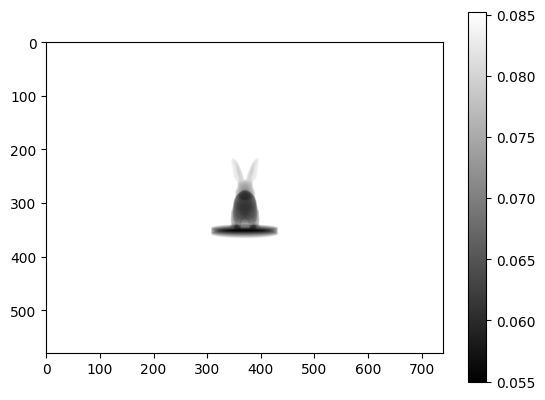

In [34]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [36]:
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 1)

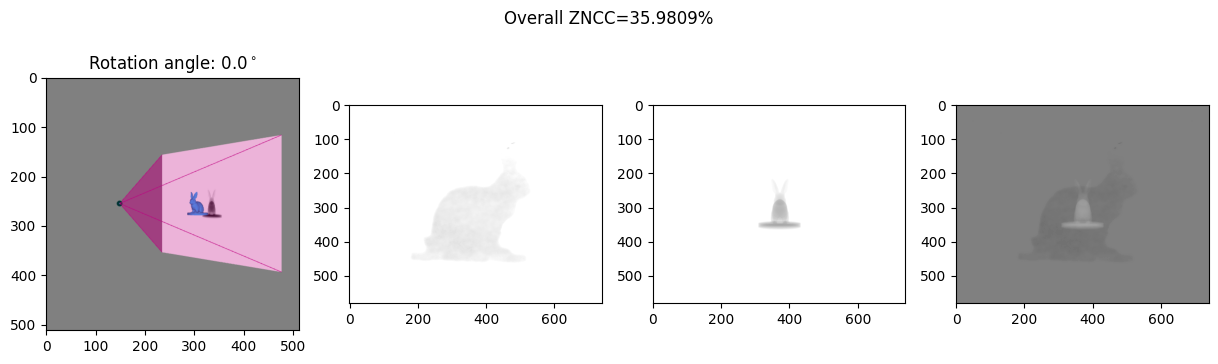

In [40]:
# # %matplotlib notebook

# displayResult(x_default)

In [60]:
# opts = cma.CMAOptions()
# opts.set('tolfun', 1e-4);
# opts['tolx'] = 1e-4;
# opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

# fname = current_folder + "/" + data_path + "/x_best1.dat"
# if not os.path.exists(fname):
    
#     best_fitness = sys.float_info.max
#     fitness_set = []
#     counter = 1
    
#     start_time = time.time();
#     es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
#     es.optimize(fitnessMAE);
#     elapsed_time = time.time() - start_time

#     x_best1 = es.result.xbest
#     np.savetxt(fname, x_best1)

#     fitness_set = np.array(fitness_set)
#     np.savetxt(current_folder + "/" + data_path + "/fitness_set1.dat", fitness_set)
# else:
#     x_best1 = np.loadtxt(fname)
#     fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set1.dat")

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=409535, Tue Nov  7 16:48:24 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.803466677665710e-02 1.0e+00 4.69e-01  5e-01  5e-01 0:06.1
    2     24 1.790940389037132e-02 1.1e+00 4.86e-01  5e-01  5e-01 0:12.8
    3     36 1.775121316313744e-02 1.2e+00 5.56e-01  5e-01  6e-01 0:24.3
    4     48 1.766343973577023e-02 1.3e+00 6.52e-01  6e-01  7e-01 0:41.9
    5     60 1.756899058818817e-02 1.3e+00 7.67e-01  7e-01  8e-01 0:49.9
    6     72 1.744974590837955e-02 1.4e+00 9.20e-01  9e-01  1e+00 0:57.4
    7     84 1.716125383973122e-02 1.4e+00 1.16e+00  1e+00  1e+00 1:04.9
    8     96 1.697126217186451e-02 1.5e+00 1.47e+00  1e+00  2e+00 1:12.4
   10    120 1.643094792962074e-02 1.5e+00 2.18e+00  2e+00  2e+00 1:29.0
   12    144 1.630135998129845e-02 1.6e+00 2.82e+00  3e+00  3e+00 1:42.6
   14    168 1.539827231317759e-02 1.5e+00 3.71e+00  3e+00  4e+00 1:58.7
   15    180 1.514942292124033e-0

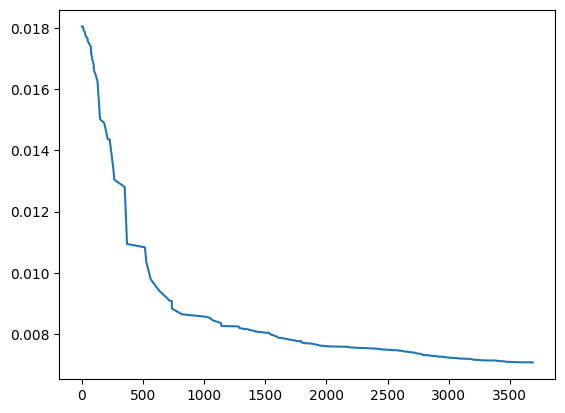

In [61]:
plt.plot(fitness_set[:,0], fitness_set[:,1])

In [64]:
# print(x_best1)

[ -19.89198162    4.74980356  167.79057074  -47.3087169    23.00483338
 -108.5054044    28.3674398     8.09190203   32.29772856   21.913777
  -47.99516094  -13.39032377   23.01269383  -15.33756007  -39.17343552]


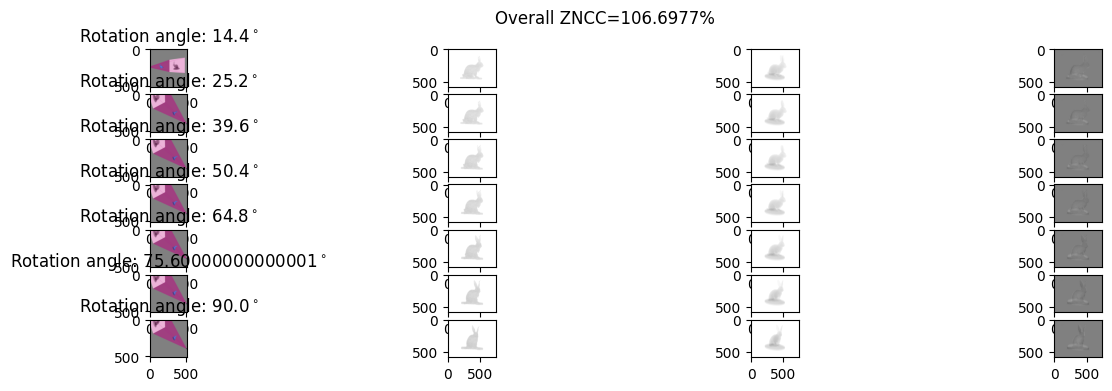

In [65]:
# displayResult(x_best1)

In [66]:
# opts = cma.CMAOptions()
# opts.set('tolfun', 1e-3);
# opts['tolx'] = 1e-3;
# opts['bounds'] = [np.hstack((12*[-1250], [-180, -180])), np.hstack((12*[1250], [180, 180]))];

# fname = current_folder + "/" + data_path + "/x_best2.dat"
# if True:
#     # not os.path.exists(fname):

#     best_fitness = sys.float_info.max
#     fitness_set = []
#     counter = 1

#     start_time = time.time();
#     es = cma.CMAEvolutionStrategy(x_best1, 0.25, opts);
#     es.optimize(fitnessMSE);
#     elapsed_time = time.time() - start_time

#     x_best2 = es.result.xbest
#     np.savetxt(fname, x_best2)

#     fitness_set = np.array(fitness_set)
#     np.savetxt(current_folder + "/" + data_path + "/fitness_set2.dat", fitness_set)
# else:
#     x_best2 = np.loadtxt(fname)
#     fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set2.dat")

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=448295, Tue Nov  7 18:38:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.911635769531131e-04 1.0e+00 2.37e-01  2e-01  2e-01 0:05.3


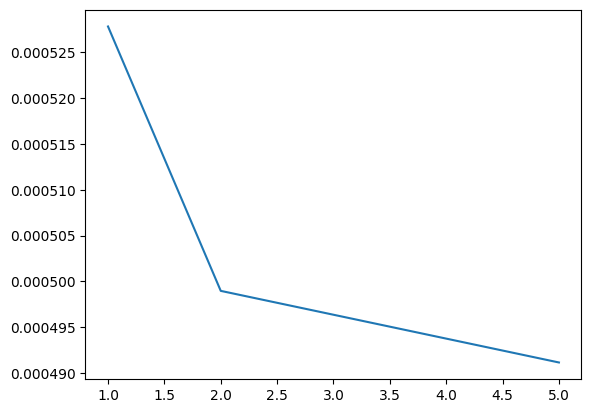

In [67]:
# plt.plot(fitness_set[:,0], fitness_set[:,1])

In [68]:
# print(x_best2)

[ -19.62036918    5.03543043  167.62493819  -46.88435754   22.64031435
 -108.33743499   28.65271773    8.1447058    31.8981216    21.93146131
  -48.3515899   -13.77870844   22.78121941  -15.30672505  -39.3199269 ]


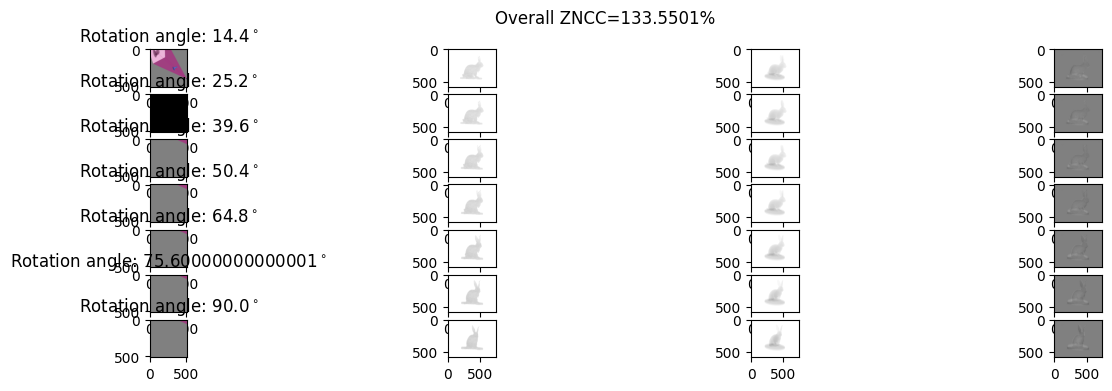

In [69]:
# displayResult(x_best2)

In [70]:
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 2)

In [79]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

fname = current_folder + "/" + data_path + "/x_best3.dat"
if True:
# if not os.path.exists(fname):

    best_fitness = sys.float_info.max
    fitness_set = []
    counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(fname, x_best3)

    fitness_set = np.array(fitness_set)
    np.savetxt(current_folder + "/" + data_path + "/fitness_set3.dat", fitness_set)
else:
    x_best3 = np.loadtxt(fname)
    fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set3.dat")

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=487018, Tue Nov  7 18:58:23 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.581591950729489e-03 1.0e+00 4.93e-01  5e-01  5e-01 0:01.5
    2     24 2.585584064945579e-03 1.2e+00 4.90e-01  5e-01  5e-01 0:02.7
    3     36 2.563421148806810e-03 1.2e+00 4.97e-01  5e-01  5e-01 0:04.2
    6     72 2.465032273903489e-03 1.4e+00 6.07e-01  6e-01  7e-01 0:08.0
   10    120 2.296440303325653e-03 1.7e+00 1.12e+00  1e+00  1e+00 0:13.0
   14    168 2.167713129892945e-03 1.8e+00 1.82e+00  2e+00  2e+00 0:18.2
   19    228 2.052503870800138e-03 1.7e+00 2.38e+00  2e+00  3e+00 0:24.2
   25    300 1.613674568943679e-03 1.9e+00 2.45e+00  2e+00  3e+00 0:31.8
   32    384 1.127133611589670e-03 2.4e+00 2.69e+00  2e+00  3e+00 0:40.3
   40    480 8.729042019695044e-04 2.8e+00 2.07e+00  2e+00  2e+00 0:49.9
   49    588 9.372072527185082e-04 2.9e+00 1.43e+00  1e+00  2e+00 1:00.6
   58    696 8.718588505871594e-0

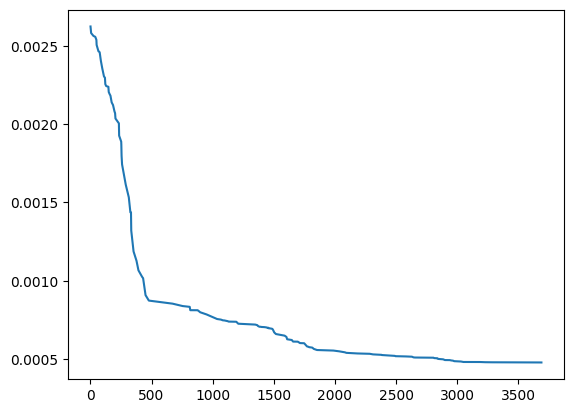

In [80]:
plt.plot(fitness_set[:,0], fitness_set[:,1])

In [81]:
print(x_best3)

[ 15.6548197  -14.18481681  76.52426002 -43.13982354  41.73785109
 -66.72330586  -7.00487262   8.93350518  12.03125238  26.26589741
 -29.49385394 -20.13186024  -8.48222783   2.6566972  -23.69731276]


In [82]:
simulated_xray_images = getXrayImage(x_best3)

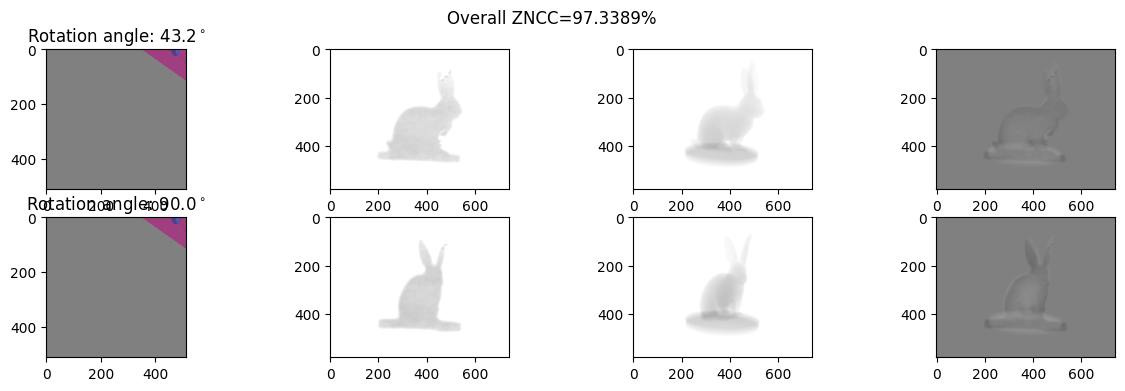

In [83]:
displayResult(x_best3)

In [84]:
# ref_image, selected_angles = getReference(I_flat, angles_in_deg, len(angles_in_deg))
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 7)

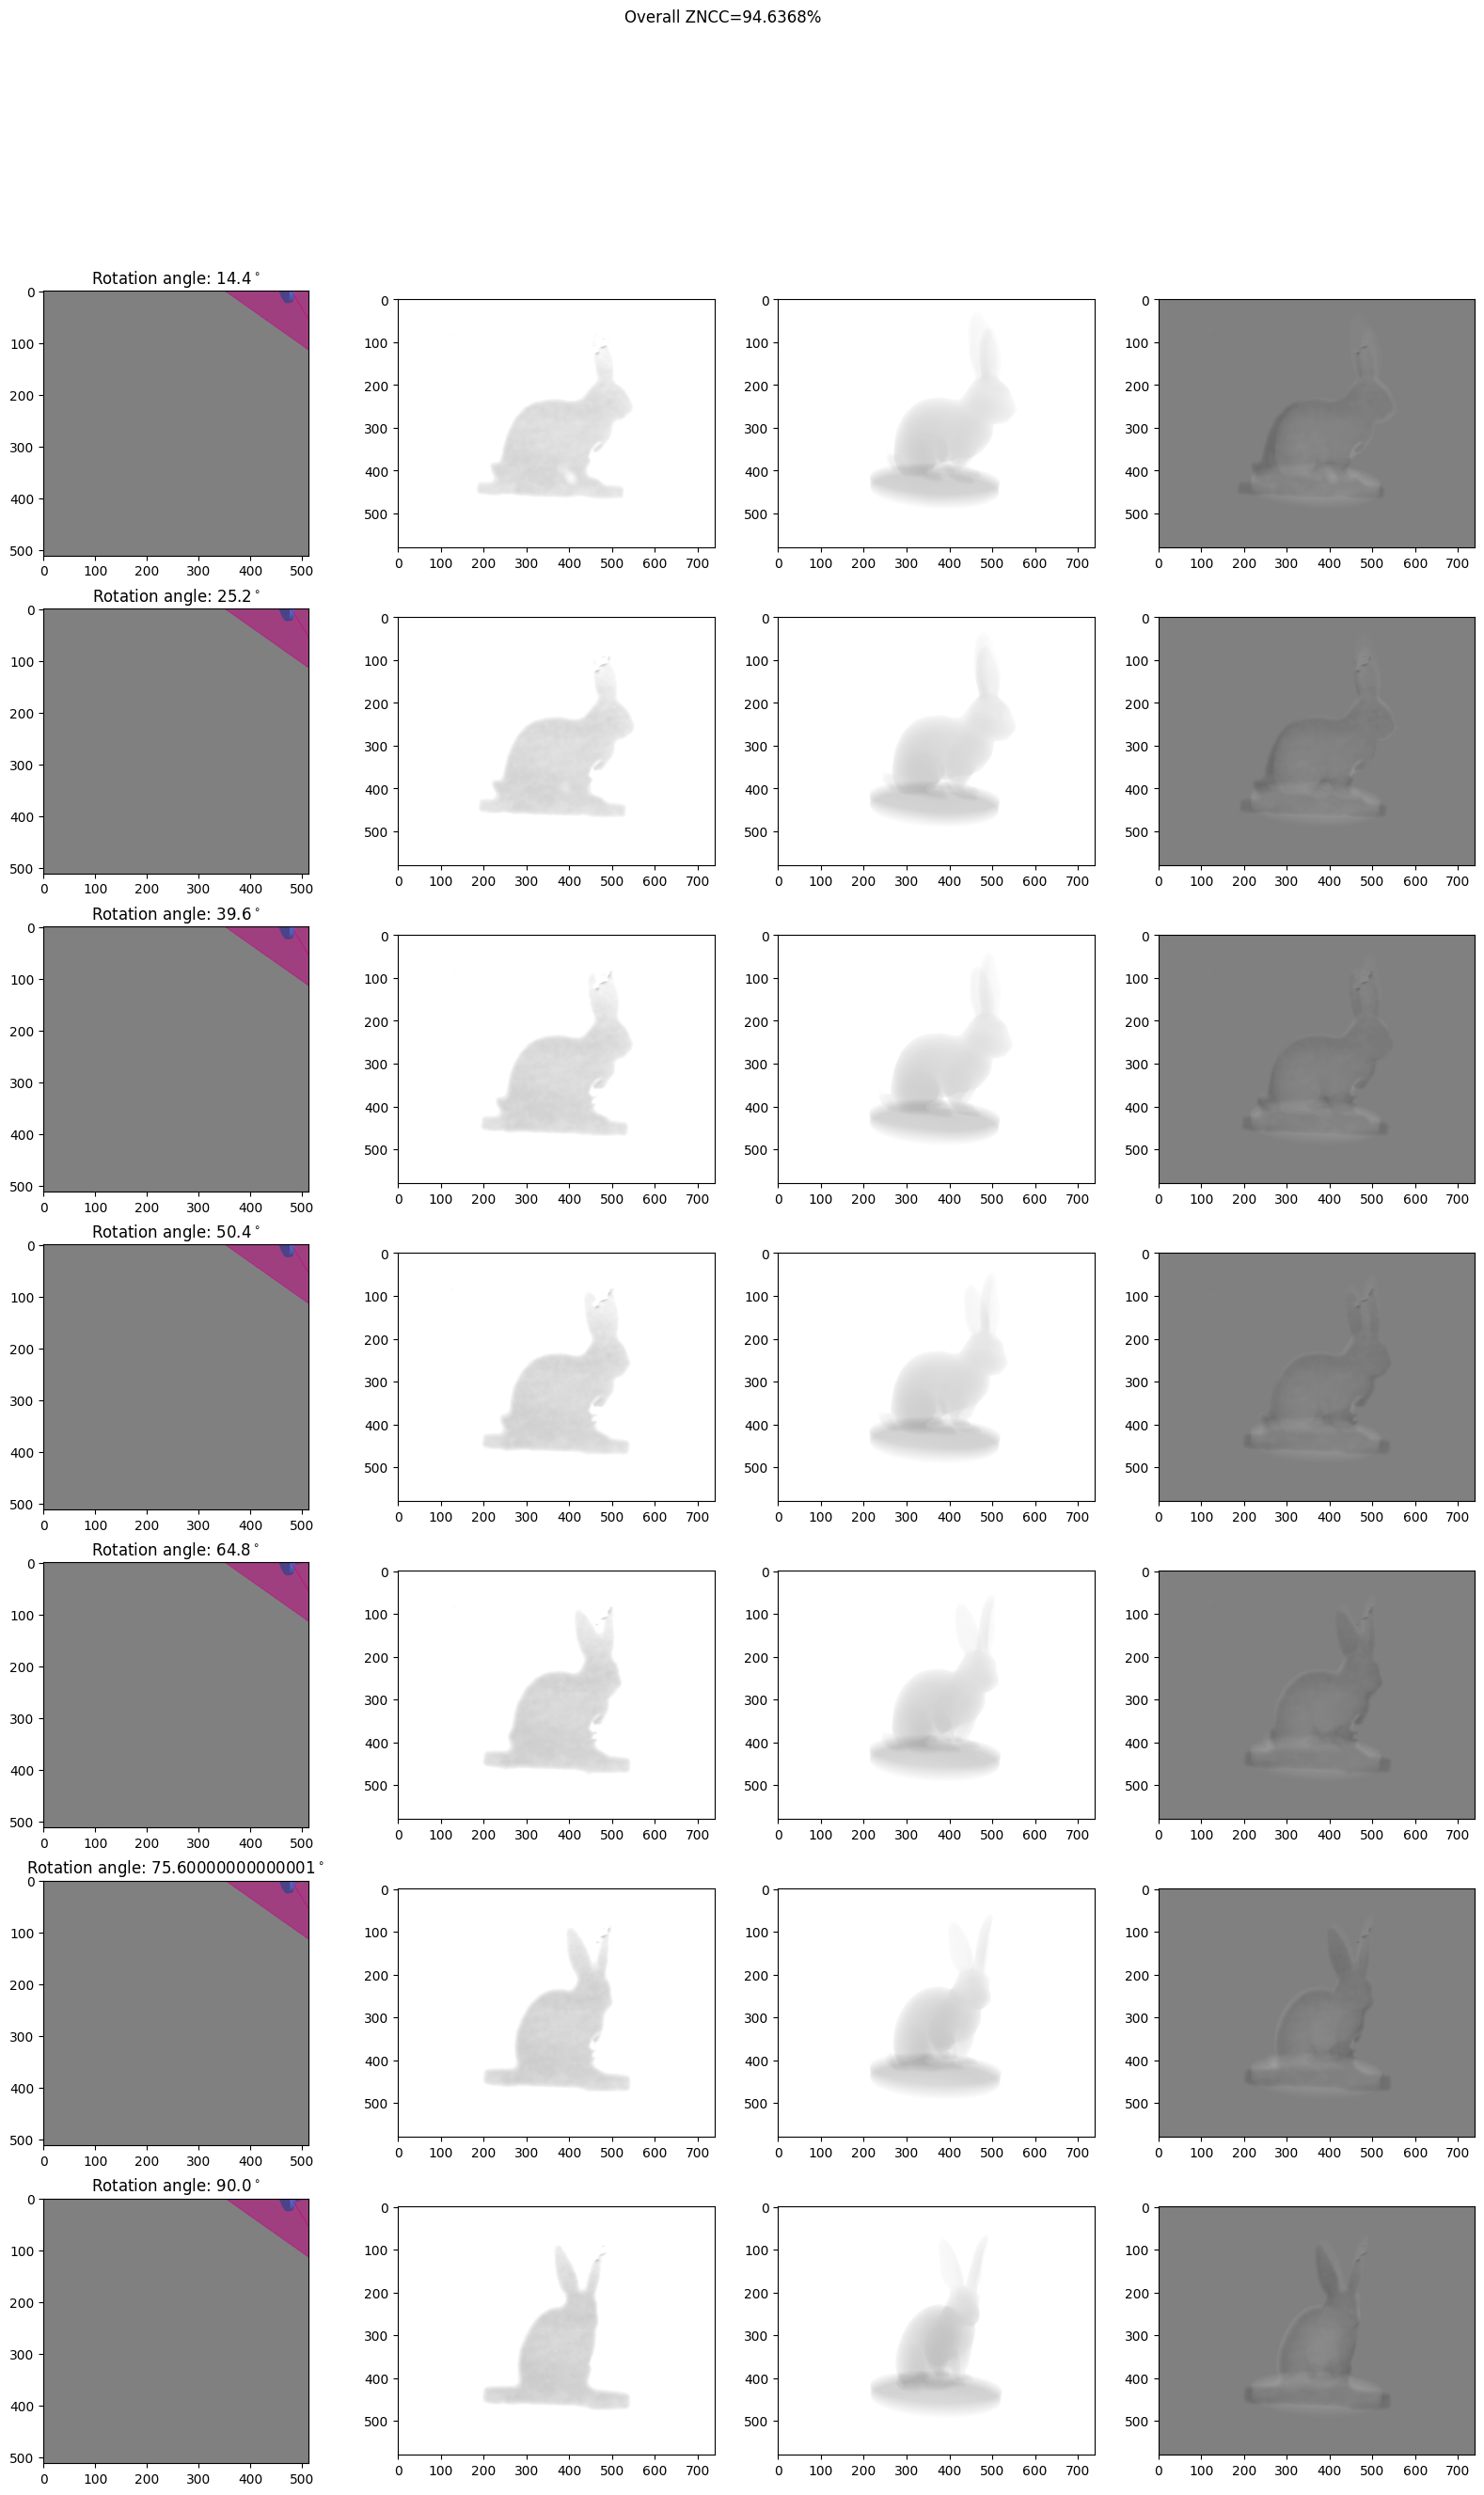

In [85]:
displayResult(x_best3, figsize=(20,30))

In [103]:
def getCentreOfRotationPosition(x):
    return [x[6], x[7], x[8]]
    
def printX(x):

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]

    x_obj1 = x[6]
    y_obj1 = x[7]
    z_obj1 = x[8]

    # alpha_x = x[9]
    # alpha_y = x[10]
    # alpha_z = x[11]

    x_obj2 = x[12]
    y_obj2 = x[13]
    z_obj2 = x[14]

        
        
    # #     gvxr.translateNode("root", x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos, "mm")
    
        
    #     gvxr.rotateNode("root", rot_angle, up_vector[0], up_vector[1], up_vector[2])
        
    #     gvxr.translateNode("root", x_obj1, y_obj1, z_obj1, "mm")

    #     gvxr.rotateNode("root", alpha_x, 1, 0, 0)
    #     gvxr.rotateNode("root", alpha_y, 0, 1, 0)
    #     gvxr.rotateNode("root", alpha_z, 0, 0, 1)
        
    #     gvxr.translateNode("root", -x_obj2, -y_obj2, -z_obj2, "mm")
        
    #     test_image.append(gvxr.computeXRayImage())
    
    #     if take_screenshot:

    #         gvxr.displayScene()        
    #         screenshot.append(gvxr.takeScreenshot())
        
    #     gvxr.setLocalTransformationMatrix("root", backup)

        
        
        
    print("Source position:", x_src, y_src, z_src, "mm")
    print("Detector position:", x_det, y_det, z_det, "mm")
    print("Source-Detector Distance (SDD):", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Object position:", x_obj2, y_obj2, z_obj2, "mm")
    print("Centre of rotation position:", getCentreOfRotationPosition(x), "mm")
    
printX(x_best3)

Source position: 15.654819700205906 -14.1848168148869 76.5242600212979 mm
Detector position: -43.13982353731727 41.73785109106068 -66.72330585614094 mm
Source-Detector Distance (SDD): 164.63298572569747 mm
Object position: -8.48222783291235 2.6566971966294264 -23.69731276228839 mm
Centre of rotation position: -7.004872616380177 8.933505183646618 12.031252375571302 mm
Centre of rotation position: [-7.004872616380177, 8.933505183646618, 12.031252375571302] mm


In [98]:


import json 

def saveJSON(fname, image_path):
    dictionary = {}

    dictionary["WindowSize"] = [800, 450]
    dictionary["Detector"] = {}
    dictionary["Detector"]["Position"] = [
        gvxr.getDetectorPosition("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorPosition("cm")[1] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorPosition("cm")[2] / gvxr.getUnitOfLength("cm"),
        "cm"]
    dictionary["Detector"]["UpVector"] = gvxr.getDetectorUpVector(),
    dictionary["Detector"]["NumberOfPixels"] = gvxr.getDetectorNumberOfPixels()
    dictionary["Detector"]["Size"] = [
        gvxr.getDetectorSize("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorSize("cm")[1] / gvxr.getUnitOfLength("cm"),
        "cm"]

    dictionary["Source"] = {}
    dictionary["Source"]["Position"] = [
        gvxr.getSourcePosition("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getSourcePosition("cm")[1] / gvxr.getUnitOfLength("cm"),
        gvxr.getSourcePosition("cm")[2] / gvxr.getUnitOfLength("cm"),
        "cm"]
    dictionary["Source"]["Shape"] = "PointSource"
    dictionary["Source"]["Beam"] = []
    
    for energy, count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):
        dictionary["Source"]["Beam"].append({})
        dictionary["Source"]["Beam"][-1]["Energy"] = energy
        dictionary["Source"]["Beam"][-1]["Unit"] = "keV"
        dictionary["Source"]["Beam"][-1]["PhotonCount"] = count

    dictionary["Samples"] = json2gvxr.params["Samples"]

    dictionary["Scan"] = {}
    dictionary["Scan"]["CenterOfRotation"] = [0, 0, 0]
    dictionary["Scan"]["FinalAngle"] = 360
    dictionary["Scan"]["IncludeFinalAngle"] = True
    dictionary["Scan"]["NumberOfProjections"] = 600
    dictionary["Scan"]["OutFolder"] = image_path


    
    # Convert and write JSON object to file
    with open(fname, "w") as outfile: 
        json.dump(dictionary, outfile)

saveJSON(current_folder + "/" + data_path + "/visible_light.json", data_path + "/flat_images/")
saveJSON(current_folder + "/" + data_path + "/simulation.json", data_path + "/simulation/")
# for i, img in enumerate(I_flat):
#     imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)